### IMPORT LIBRARIES

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [52]:
#AUTOTUNE = tf.data.experimental.AUTOTUNE

In [53]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [54]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
alzheimers-dataset-4-class-of-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [55]:
import zipfile
local_zip = '/content/alzheimers-dataset-4-class-of-images.zip'
data = zipfile.ZipFile(local_zip, 'r')
data.extractall('/content/Alzheimer_s Dataset')
data.close()

In [100]:

train_dataset  = train_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [101]:

valid_dataset = valid_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  shuffle=True,
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


In [102]:
#test_dataset = tf.keras.preprocessing.image_dataset_from_directory("../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test",
##                                                            shuffle=False,
#                                                            image_size=(224,224),
#                                                            batch_size=32,
#)

test_dataset = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                batch_size = 1, shuffle = False
                                              )

Found 1279 images belonging to 4 classes.


## feature preprocessing and label encoding.

### MODEL BUILDING

In [103]:
from tensorflow.keras.applications import ResNet101 # ResNet 101
base_model = ResNet101(input_shape=(224,224,3), weights='imagenet', include_top=False)


In [104]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable = False


In [105]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [106]:
#pretrained_model = tf.keras.applications.resnet50.ResNet50(
#                    input_shape=(224, 224, 3),
#                    include_top=False,
 #                   weights= None ,
  #                  pooling='avg')

#pretrained_model.trainable = False
#inputs = pretrained_model.input
#x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
#x = tf.keras.layers.Dense(50, activation='relu')(x)
#outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
#model = tf.keras.Model(inputs, outputs)
#print(model.summary())

In [107]:
# Model Summary

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_12 (Bat  (None, 100352)           401408    
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 2048)              205522944 
                                                                 
 batch_normalization_13 (Bat  (None, 2048)             8192      
 chNormalization)                                     

In [108]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [109]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001) #improve weights 
METRICS = [
      tensorflow.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc') ,
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
filepath = '/content/drive/MyDrive/best_weights_resnet50_final.hdf5'

earlystopping = EarlyStopping(monitor = 'val_Categorical Accuracy', 
                              mode = 'max' , 
                              patience = 25,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_Categorical Accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [112]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        verbose = 1,
                         callbacks=callback_list)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.5205 - Categorical Accuracy: 0.4568 - precision: 0.4717 - recall: 0.4126 - auc: 0.7419 - f1_score: 0.4403
Epoch 1: val_Categorical Accuracy improved from -inf to 0.31476, saving model to /content/drive/MyDrive/best_weights_resnet50_final.hdf5
33/33 [==============================] - 86s 2s/step - loss: 1.5205 - Categorical Accuracy: 0.4568 - precision: 0.4717 - recall: 0.4126 - auc: 0.7419 - f1_score: 0.4403 - val_loss: 1.8511 - val_Categorical Accuracy: 0.3148 - val_precision: 0.3053 - val_recall: 0.2874 - val_auc: 0.6083 - val_f1_score: 0.2958
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 1.2434 - Categorical Accuracy: 0.4905 - precision: 0.5154 - recall: 0.4368 - auc: 0.7820 - f1_score: 0.4788
Epoch 2: val_Categorical Accuracy improved from 0.31476 to 0.48387, saving model to /content/drive/MyDrive/best_weights_resnet50_final.hdf5
33/33 [==============================] - 76s 2s/step - loss:

dict_keys(['loss', 'Categorical Accuracy', 'precision', 'recall', 'auc', 'f1_score', 'val_loss', 'val_Categorical Accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_f1_score'])


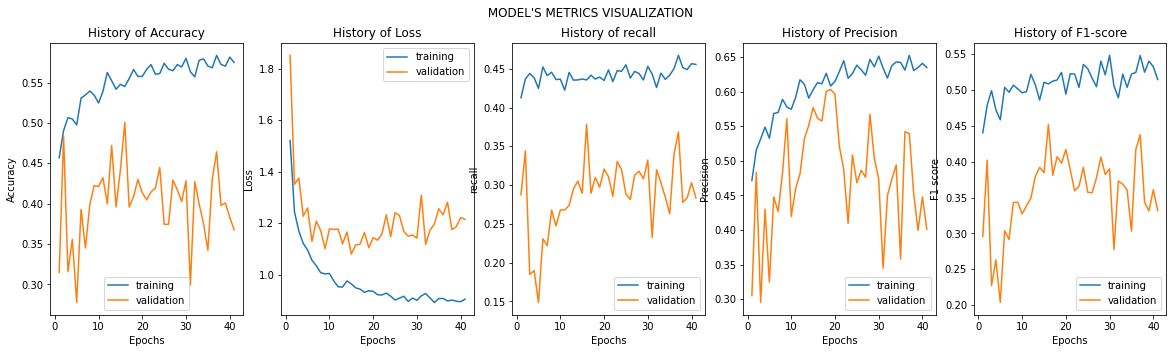

In [113]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,recall,val_recall,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(recall) + 1), recall)
    ax3.plot(range(1, len(val_recall) + 1), val_recall)
    ax3.set_title('History of recall')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('recall')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    
print(history.history.keys())
Train_Val_Plot(history.history['Categorical Accuracy'],history.history['val_Categorical Accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['recall'],history.history['val_recall'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [119]:
scores = model.evaluate(test_dataset)

1279/1279 [==============================] - 33s 26ms/step - loss: 0.9635 - Categorical Accuracy: 0.5426 - precision: 0.5582 - recall: 0.4988 - auc: 0.8323 - f1_score: 0.4988


In [120]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("F1_score = ", scores[4])

Accuracy =  0.5426114201545715
Precision =  0.5581802129745483
Recall =  0.4988272190093994
F1_score =  0.8323396444320679


In [121]:
true_classes = test_dataset.classes
class_indices = test_dataset.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

resnet50_preds = model.predict(test_dataset)
resnet50_pred_classes = np.argmax(resnet50_preds, axis=1)

1279/1279 [==============================] - 36s 28ms/step


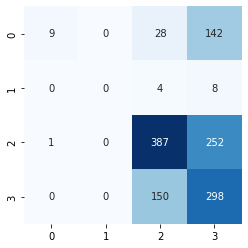

In [122]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_dataset.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, resnet50_pred_classes)    

plt.show()

In [123]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

Saving kaggle.json to kaggle (4).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
alzheimer-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [124]:
import zipfile
local_zip = '/content/alzheimer-mri-dataset.zip'
data = zipfile.ZipFile(local_zip, 'r')
data.extractall('/content/Alzheimer_s Dataset_2')
data.close()

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
test_datagen2  = ImageDataGenerator(rescale = 1./255)
# Test Data 

test_dataset2  = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset_2/Dataset',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 1)

Found 6400 images belonging to 4 classes.


In [127]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [128]:
# Evaluating Loss and AUC

model.evaluate(test_dataset2)

6400/6400 [==============================] - 187s 29ms/step - loss: 0.8877 - Categorical Accuracy: 0.5672 - precision: 0.6059 - recall: 0.4870 - f1_score: 0.4870


[0.8876709938049316,
 0.567187488079071,
 0.6059486865997314,
 0.4870312511920929,
 0.4870312213897705]

In [80]:
def predict_prob(number):
  return [number[0],1-number[0]]

1/1 [==============================] - 0s 30ms/step
64.98 % chances are there that the image is [2]


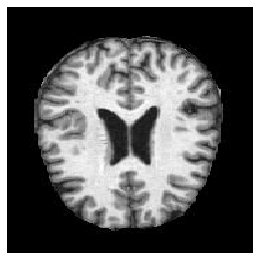

In [81]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test/NonDemented/26 (95).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)